In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
import sys

sys.path.append("..")
from data_utils import data_process, batchify, get_batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [4]:
from torch.utils.data import dataset
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


train_iter = WikiText2(split="train")
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter, vocab, tokenizer)
val_data = data_process(val_iter, vocab, tokenizer)
test_data = data_process(test_iter, vocab, tokenizer)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size, device)
val_data = batchify(val_data, eval_batch_size, device)
test_data = batchify(test_data, eval_batch_size, device)

In [5]:
idx2word = {i: x for i, x in enumerate(vocab.get_itos())}

def to_sentence(x):
    return " ".join([idx2word[int(idx)] for idx in x])

def to_tokens(x):
    return [idx2word[int(idx)] for idx in x]

data, _ = get_batch(train_data, batch_size*2, bptt=100)
to_sentence(data[:, 0])

'video game developed by sega and media . vision for the playstation portable . released in january 2011 in japan , it is the third game in the valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the nameless , a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit <unk> raven . the game began development in 2010 , carrying over a large portion'

## Model

In [78]:
from torch import nn, Tensor
from multihead_attention import MultiheadAttention
from positional_encoding import PositionalEncoding
from transformer_encoder import TransformerEncoder, TransformerEncoderLayer

In [90]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float("-inf"), diagonal=1)

class Model(nn.Module):
    def __init__(self, n_tokens, D, Dff, B, n_heads, n_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, D)
        self.pe = PositionalEncoding(D, dropout=0)
        # self.encoder = MultiheadAttention(D, n_heads, bias=True)
        
        encoderLayer = TransformerEncoderLayer(D, n_heads, Dff)
        self.encoder = TransformerEncoder(encoderLayer, n_layers)
        self.decoder = nn.Linear(D, n_tokens)
        
        self._init_parameters()
    
    def _init_parameters(self):
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-0.1, 0.1)

    def forward(self, src, attn_mask):
        """ 
        Args: 
            src: tensor, shape [B, N]
        """
        # (B, N, D)
        src = self.embedding(src)
        # print(src[0])
        
        
        
        src = self.pe(src)
        # print(src[0])
        
        # print("embedding  : ", src.shape)
        
        # (B, N, D), (B, n_heads, N, N)
        # attn_output, attn_mask =self.encoder(src, src, src, attn_mask = attn_mask)
        attn_output, attn_weights =self.encoder(src, attn_mask)
        # print(attn_output[0])
        
        # (B, N, n_tokens)
        output = self.decoder(attn_output)
        return output, attn_weights
        
        
D, Dff = 16, 64
N = 8
n_heads = 4
n_layers = 2
n_tokens = len(vocab)        

torch.manual_seed(12)
model = Model(n_tokens, D, Dff, batch_size, n_heads, n_layers=n_layers)
mask = generate_square_subsequent_mask(N)
# model

## Train

In [93]:
lr = 5.0
log_interval = 200
epochs = 1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

In [104]:
epochs = 5
log_interval = 1000

In [105]:
model.train()

for e in range(epochs):
    total_loss = 0
    for b, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, bptt=N)
        if data.shape[1] != batch_size:
            print("incomplete")
            break

        output, _ = model(data.t(), mask)

        loss = criterion(output.view(-1, n_tokens), targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()

        if b % log_interval == 0 and i !=0:
            lr = scheduler.get_last_lr()[0]
            print(f"({e}|{b}) loss: {total_loss/log_interval:<.3f} || lr: {lr:<.3f}")
            # scheduler.step()
            total_loss = 0

    scheduler.step()

(0|1000) loss: 6.505 || lr: 4.287
(0|2000) loss: 6.485 || lr: 4.287
(0|3000) loss: 6.589 || lr: 4.287
(0|4000) loss: 6.535 || lr: 4.287
(0|5000) loss: 6.462 || lr: 4.287
(1|1000) loss: 6.455 || lr: 4.073
(1|2000) loss: 6.466 || lr: 4.073
(1|3000) loss: 6.495 || lr: 4.073
(1|4000) loss: 6.439 || lr: 4.073
(1|5000) loss: 6.413 || lr: 4.073
(2|1000) loss: 6.401 || lr: 3.869
(2|2000) loss: 6.405 || lr: 3.869
(2|3000) loss: 6.406 || lr: 3.869
(2|4000) loss: 6.390 || lr: 3.869
(2|5000) loss: 6.377 || lr: 3.869
(3|1000) loss: 6.358 || lr: 3.675
(3|2000) loss: 6.353 || lr: 3.675
(3|3000) loss: 6.357 || lr: 3.675
(3|4000) loss: 6.330 || lr: 3.675
(3|5000) loss: 6.304 || lr: 3.675
(4|1000) loss: 6.302 || lr: 3.492
(4|2000) loss: 6.304 || lr: 3.492
(4|3000) loss: 6.319 || lr: 3.492
(4|4000) loss: 6.290 || lr: 3.492
(4|5000) loss: 6.263 || lr: 3.492


output sentence: s , , the . s <unk> ,


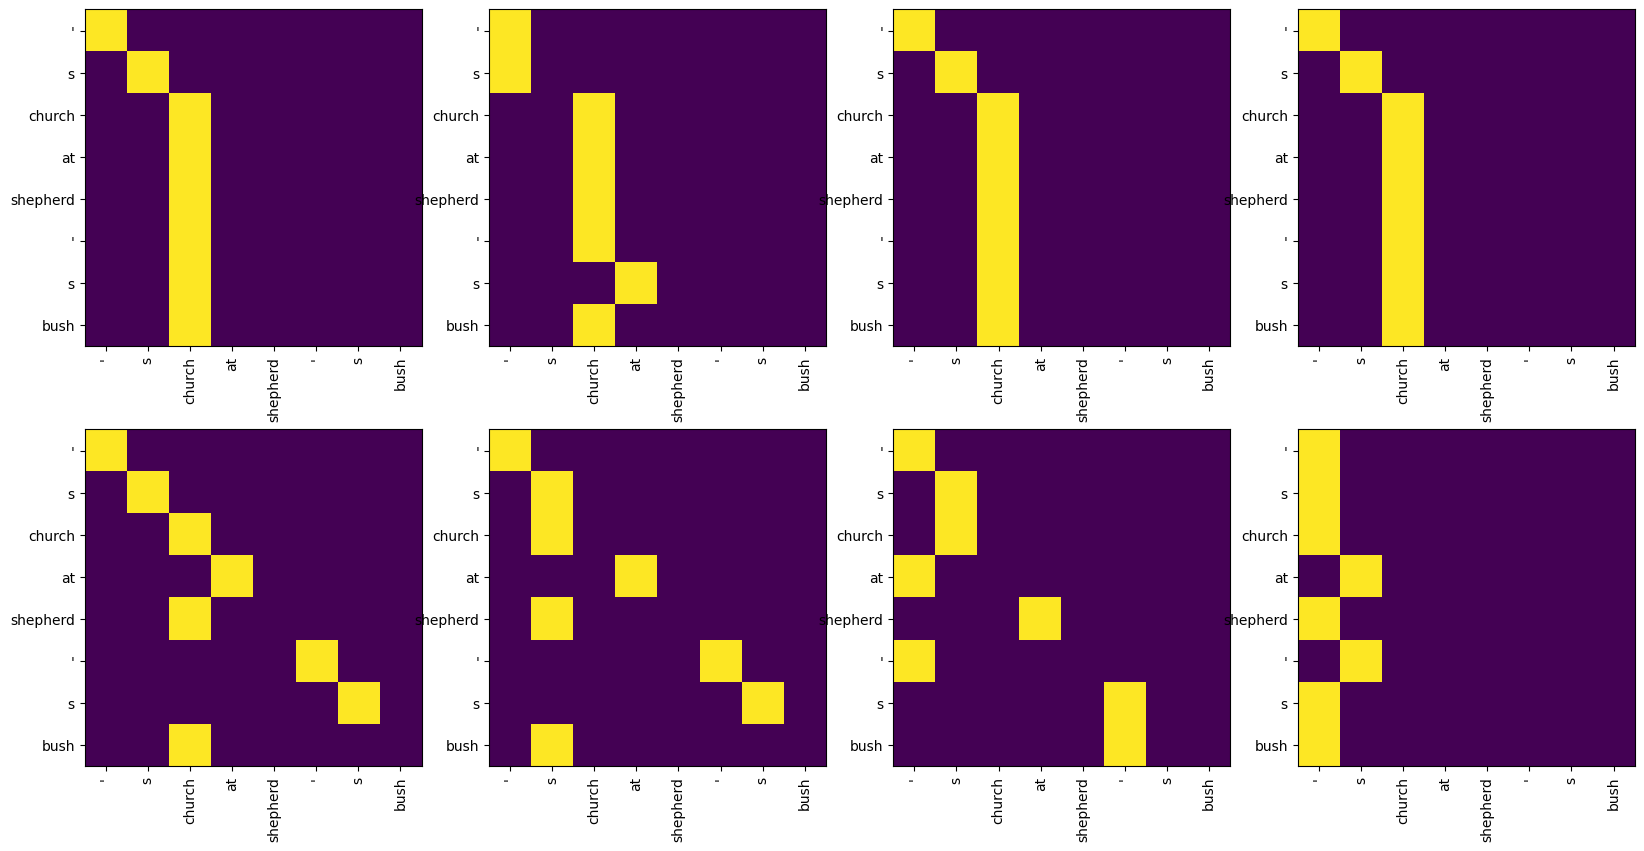

In [111]:
### look at attn weights

import matplotlib.pyplot as plt
import random

model.eval()

idx = random.randint(0, train_data.size(0))
data, targets = get_batch(train_data, idx , bptt=N)
data = data[:, :1]


output, attn_weights = model(data.t(), mask)

output_sentence = to_sentence(output.argmax(-1).squeeze())
print(f"output sentence: {output_sentence}")

labels = to_tokens(data.squeeze())

_, ax = plt.subplots(max(n_layers, 2), max(n_heads, 2), figsize=(5 * n_heads, n_layers * 5))
for i in range (n_layers):
    for j in range(n_heads):
        ax[i, j].imshow(attn_weights[i][0, j].detach())
        ax[i, j].set_xticks(range(N))
        ax[i, j].set_yticks(range(N))
        ax[i, j].set_xticklabels(labels, rotation=90)
        ax[i, j].set_yticklabels(labels, rotation=0)
    
plt.show()